# Aimes, Iowa Housing Data: Preprocessing, Model Fitting and Analysis (All Terms, Lasso Regression)

We now look at the results of throwing in all terms and using Lasso regression.

In [1156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, LinearRegression
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.decomposition import PCA
import patsy
from sklearn.metrics import mean_squared_error
from functools import reduce

import pickle
from itertools import combinations

np.random.seed(1)

In [1061]:
fileObj = open('./pickles/housingDF.pkl', 'rb')
housing = pickle.load(fileObj)
fileObj.close()

In [1062]:
housing = housing.query('SalePrice < 570000')

In [1063]:
areas = housing.loc[:,housing.columns.map(lambda name: 'SF' in name or 'Area' in name)].columns
quals = housing.loc[:,housing.columns.map(lambda name: 'Qual' in name)].columns
types = housing.loc[:,housing.columns.map(lambda name: 'Type' in name or 'MS' in name)].columns

In [1064]:
areas = reduce((lambda x,y: x + ' + ' + y), areas)
quals = reduce((lambda x,y: x + ' + ' + y), quals)
types = reduce((lambda x,y: x + ' + ' + y), types)

In [1065]:
areas

'LotArea + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + SecondFlrSF + LowQualFinSF + GrLivArea + GarageArea + WoodDeckSF + OpenPorchSF + PoolArea'

In [1066]:
type_combos = list(combinations(types,2))

In [1067]:
type_strings = []
for combo in type_combos:
    type_strings.append(combo[0] + ':' + combo[1])
    
type_strings = reduce((lambda x,y: x + ' + ' + y), type_strings)

In [1068]:
areas

'LotArea + MasVnrArea + BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF + TotalBsmtSF + SecondFlrSF + LowQualFinSF + GrLivArea + GarageArea + WoodDeckSF + OpenPorchSF + PoolArea'

In [1069]:
quals

'OverallQual + ExterQual + BsmtQual + LowQualFinSF + KitchenQual + GarageQual'

In [1070]:
types

'MSSubClass + MSZoning + BldgType + MasVnrType + BsmtFinType1 + BsmtFinType2 + GarageType + SaleType'

In [1071]:
terms = reduce((lambda x,y: x + ' + ' + y),housing.drop(['SalePrice'], axis=1).columns)
interactions = 'GrLivArea:OverallQual + GrLivArea:OverallQual:(ExterQual + Neighborhood + SaleType)'
formula = f'SalePrice ~ {terms} + {interactions} - 1'
y, x = patsy.dmatrices(formula, housing)
x = pd.DataFrame(x, columns=x.design_info.column_names)

In [1144]:
model = Lasso(alpha=400)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3)

scaler = StandardScaler()
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

#decomp = PCA(n_components=50)
#xtrain = decomp.fit_transform(xtrain)
#xtest = decomp.transform(xtest)
#ytrain = np.log(ytrain)[:,0]
#ytest = np.log(ytest)[:,0]

In [1145]:
model.fit(xtrain, ytrain)
print(f'The model\'s R^2 score is {model.score(xtrain, ytrain)} on the training data, {model.score(xtest, ytest)} on the test data.')

The model's R^2 score is 0.9436751758169697 on the training data, 0.9443837756931359 on the test data.


In [1146]:
mean_squared_error(ytest, model.predict(xtest))**0.5

18015.48773381194

In [1147]:
mean_squared_error(y, model.predict(scaler.transform(x)))**0.5

18249.166748426727

In [1148]:
scores = cross_val_score(model, xtrain, ytrain.ravel(), cv=5, scoring='neg_mean_squared_error')
print(f'With 5 folds, the RMSE is {abs(np.mean(scores))**0.5} +- {np.std(scores)**0.5}')

With 5 folds, the RMSE is 23344.257349867654 +- 13614.265567457407


No change on a scale we would care about.  The dominant term is quality square footage, and external quality adds and additional effect, as advertised.

In [1149]:
coefs = pd.DataFrame(model.coef_, index=x.columns, columns=['Weight']).sort_values(by='Weight', ascending=False)
coefs.abs().head(50)

,Weight
GrLivArea:OverallQual,37912.322922
BsmtFinSF1,8546.147519
TotalBsmtSF,6695.799519
GrLivArea:OverallQual:Neighborhood[T.NridgHt],5430.248594
GarageArea,5184.945865
GrLivArea:OverallQual:Neighborhood[T.StoneBr],5109.446447
OverallCond,5041.307250
YearBuilt,5000.459215
LotArea,4814.946358
GrLivArea:OverallQual:SaleType[T.New],4281.589832


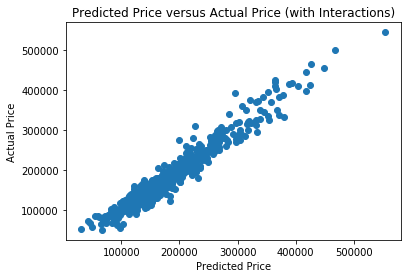

In [1150]:
plt.scatter(model.predict(xtest), ytest);
plt.title('Predicted Price versus Actual Price (with Interactions)')
#plt.plot((0,max(ytest)), (0, max(ytest)), linestyle='dashed', color='k')
plt.ylabel('Actual Price')
plt.xlabel('Predicted Price');

At first glance, these predictions look closer.  In this sample, though, we did not have the nearly $600,000 houses in our test data, so it would not immediatley be fair to say that we would be prepared to predict the price of that house.  Looking to see if we were at least able to fit to it in our training data,

We go ahead in submitting this model for kaggle.

In [1151]:
name = 'lessout'

In [1152]:
fileFormula = open('./pickles/formula'+name+'.pkl', 'wb')
pickle.dump(formula, fileFormula)
fileFormula.close()

In [1153]:
fileScaler = open('./pickles/scaler'+name+'.pkl', 'wb')
pickle.dump(scaler, fileScaler)
fileScaler.close()

In [1154]:
fileModel = open('./pickles/model'+name+'.pkl', 'wb')
pickle.dump(model, fileModel)
fileModel.close()

In [1155]:
fileColumns = open('./pickles/columns'+name+'.pkl', 'wb')
pickle.dump(x.columns, fileColumns)
fileColumns.close()